# Check Continuum Fit

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import sys
sys.path.append('../')
from utils import *

In [2]:
ids = 1
dset_dir = os.path.join(essp_dir,'Training',f'DS{ids}','Spectra')

In [3]:
cont_dict = {}
for inst in instruments:
    file_list = glob(os.path.join(dset_dir,f'DS{ids}*_{inst}.fits'))
    num_obs = len(file_list)
    num_ord = None
    for ifile, file in enumerate(tqdm(file_list,desc=inst)):
        hdus = fits.open(file)
        wave = hdus['wavelength'].data.copy()
        flux = hdus['flux'].data.copy()
        blaz = hdus['blaze'].data.copy()
        cont = hdus['continuum'].data.copy()
        hdus.close()
        if num_ord is None:
            num_ord,num_pix = wave.shape
            conts = np.empty((2,num_ord,num_obs))
        
        snr_mask = np.sqrt(flux)>100
        spec_norm = flux/cont
        for iord in range(num_ord):
            cont_blue = np.nanmedian(np.sort(spec_norm[iord][snr_mask[iord]][:100])[75:95])
            cont_redd = np.nanmedian(np.sort(spec_norm[iord][snr_mask[iord]][-100:])[75:95])
            conts[:,iord,ifile] = cont_blue,cont_redd
    cont_dict[inst] = conts

harpsn:   0%|                                                     | 0/84 [00:00<?, ?it/s]/opt/miniconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/4w/sk_022310js2sk72473745kr0000gn/T/ipykernel_1162/1451470722.py:17: RuntimeWarning: invalid value encountered in sqrt
  snr_mask = np.sqrt(flux)>100
neid: 100%|██████████████████████████████████████████████| 84/84 [00:14<00:00,  5.99it/s]


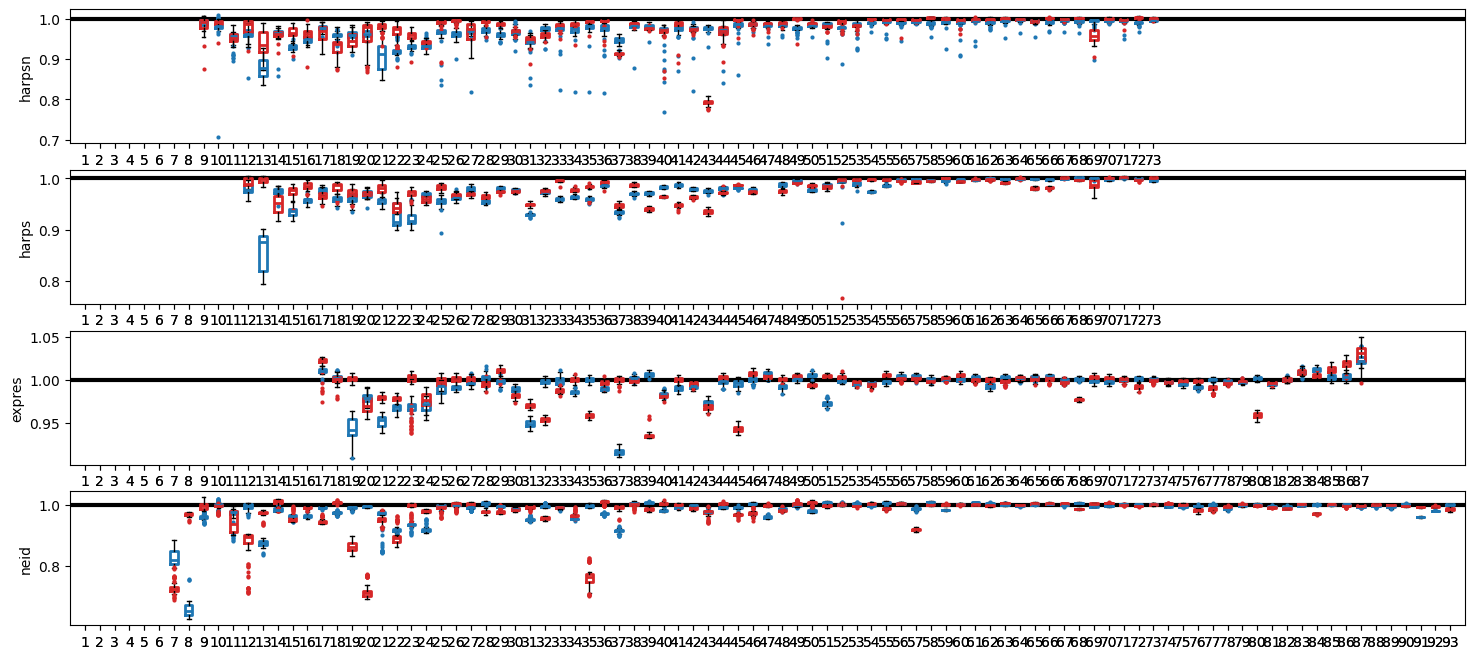

In [4]:
fig, axes = plt.subplots(len(instruments),1,figsize=(18,8))
for iinst,inst in enumerate(instruments):
    cont_arry = cont_dict[inst]
    ax = axes[iinst]
    ax.set_ylabel(inst)
    ax.axhline(1,color='k',lw=3)
    for i in range(2):
        box_col = f'C{i*3}'
        boxprops = dict(linewidth=2, color=box_col)
        flierprops = dict(marker='.', markerfacecolor=box_col, mec='None')
        medianprops = dict(linewidth=2, color=box_col)
        ax.boxplot(cont_arry[i].T,boxprops=boxprops,flierprops=flierprops,medianprops=medianprops);
    ax.set_xlim(0,94)

/var/folders/4w/sk_022310js2sk72473745kr0000gn/T/ipykernel_1162/2646894586.py:2: RuntimeWarning: All-NaN slice encountered
  cont_meds = np.nanmedian(cont_dict[inst],axis=-1)
neid: 100%|█████████████████████████████████████████████| 84/84 [00:00<00:00, 142.63it/s]


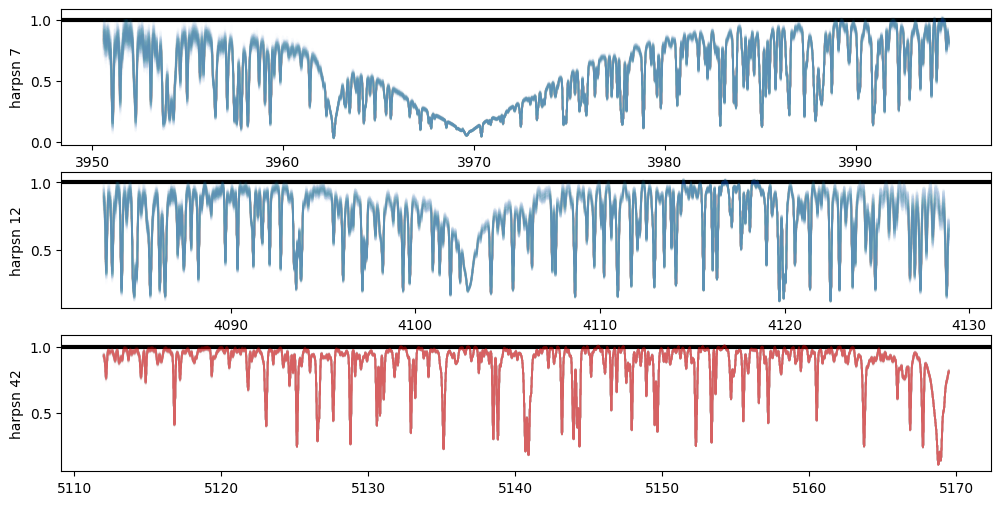

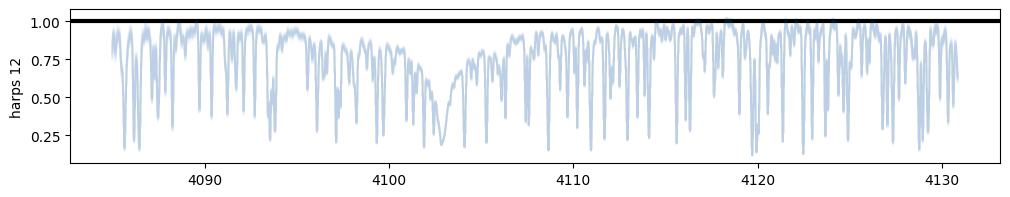

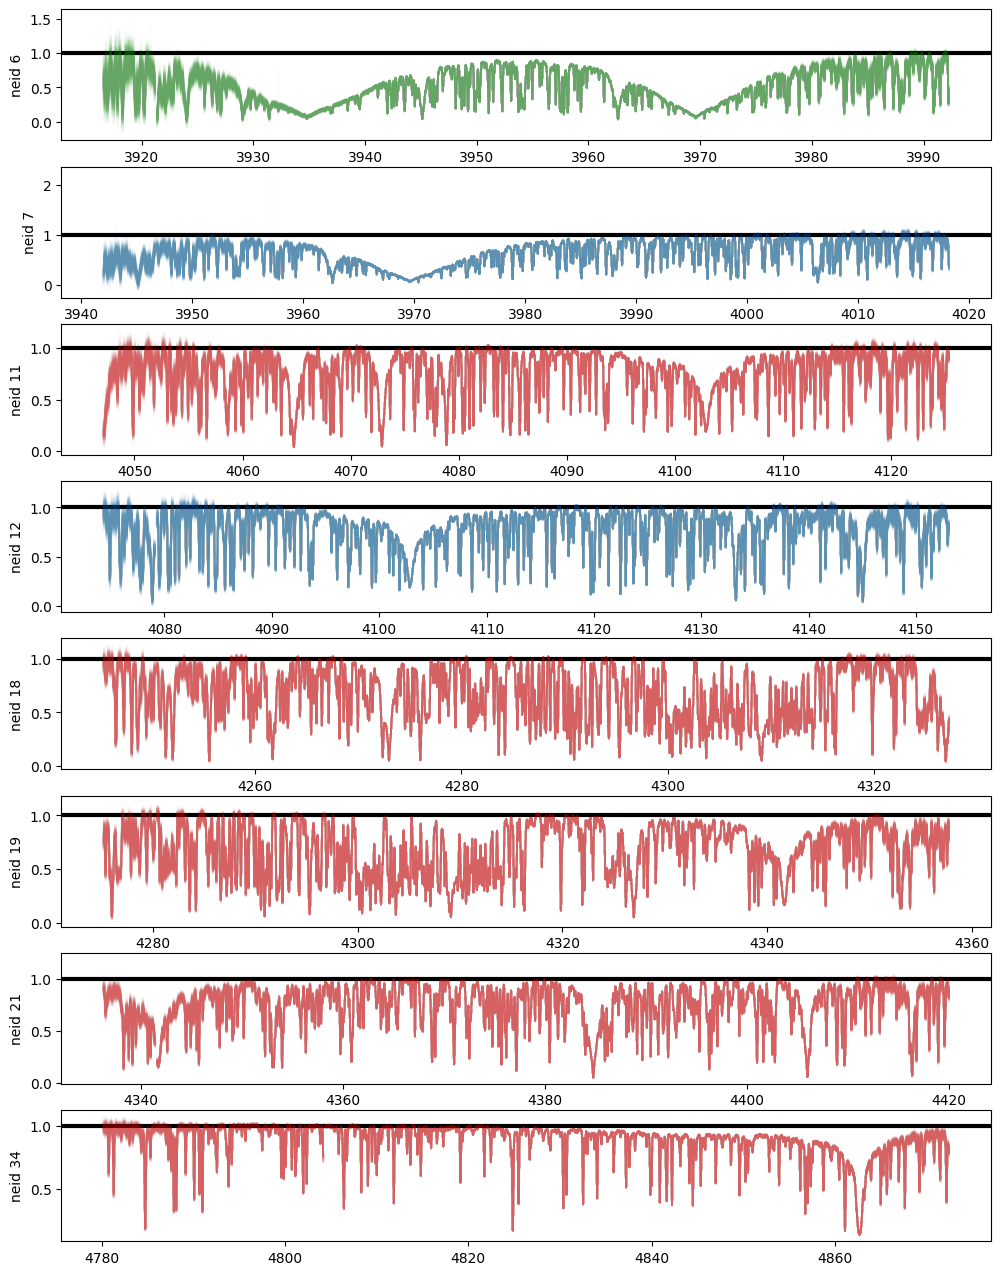

In [5]:
for iinst,inst in enumerate(instruments):
    cont_meds = np.nanmedian(cont_dict[inst],axis=-1)
    num_ord = len(cont_meds[0])
    blue_list = np.arange(num_ord)[np.abs(1-cont_meds[0])>0.1]
    redd_list = np.arange(num_ord)[np.abs(1-cont_meds[1])>0.1]
    ord_list = []
    for iord in np.unique(np.concatenate([blue_list,redd_list])):
        if iord in blue_list:
            if iord in redd_list: # iord in both lists
                ord_list.append((iord,2))
            else: # iord only in blue list
                ord_list.append((iord,0))
        else: # iord only in red list
            ord_list.append((iord,3))
    if len(ord_list)==0:
        continue
    ord_list, ord_cols = np.array(ord_list).T
    
    fig, axes = plt.subplots(len(ord_list),1,figsize=(12,len(ord_list)*2))
    if len(ord_list)==1:
        axes = [axes]
    for iord,nord in enumerate(ord_list):
        axes[iord].set_ylabel(f'{inst} {nord}')
        axes[iord].axhline(1,color='k',lw=3)
    
    file_list = glob(os.path.join(dset_dir,f'DS{ids}*_{inst}.fits'))
    for ifile, file in enumerate(tqdm(file_list,desc=inst)):
        hdus = fits.open(file)
        wave = hdus['wavelength'].data.copy()
        flux = hdus['flux'].data.copy()/hdus['continuum'].data.copy()
        hdus.close()
        for iord,nord in enumerate(ord_list):
            axes[iord].plot(wave[nord],flux[nord],color=f'C{ord_cols[iord]}',alpha=0.01)